# NYC Taxi Fare Predictor

**Kaggle Prediction Competition**:                                        
[New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)  

**File descriptions**
- train.csv - Input features and target fare_amount values for the training set (about 55M rows).                     
- test.csv - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.                         
- sample_submission.csv - a sample submission file in the correct format (columns key and fare_amount). This file 'predicts' fare_amount to be 11.35 US dollar for all rows, which is the mean fare_amount from the training set.                                  

**Data fields** 
- key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.                    

**Features**
- pickup_datetime - timestamp value indicating when the taxi ride started.           
- pickup_longitude - float for longitude coordinate of where the taxi ride started.                        
- pickup_latitude - float for latitude coordinate of where the taxi ride started.                           
- dropoff_longitude - float for longitude coordinate of where the taxi ride ended.                           
- dropoff_latitude - float for latitude coordinate of where the taxi ride ended.                             
- passenger_count - integer indicating the number of passengers in the taxi ride.       

**Target**                                      
- fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.                                      

In [1]:
# import modules
import gcsfs # necessary for reading csv from GCP storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data sourcing

- train and test data are downloaded and stored in GCP storage
- let's start with first 2 million rows for training

In [25]:
%%time
# read the train.csv directly from GCP cloud storage
url = 'gs://nyc_taxifare_predictor/data/train.csv'
df = pd.read_csv(url, nrows=2000000, encoding='utf-8')
df.head()

Wall time: 26.3 s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## Target exploration

In [4]:
# statistic summary of target variable: fare amount
df.fare_amount.describe()

count    1000000.000000
mean          11.348079
std            9.822090
min          -44.900000
25%            6.000000
50%            8.500000
75%           12.500000
max          500.000000
Name: fare_amount, dtype: float64

In [5]:
# drop non-realistic fare amounts
df = df[df.fare_amount.between(0, 200)]
df = df[df.fare_amount!=0]
df.fare_amount.describe()

count    999895.000000
mean         11.339173
std           9.673510
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         200.000000
Name: fare_amount, dtype: float64

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

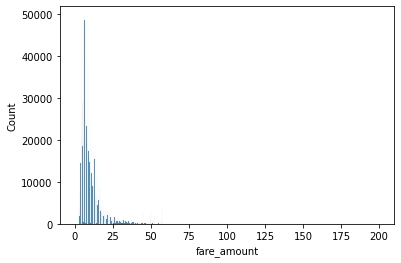

In [6]:
# check out the distribution of dare_amount
sns.histplot(df['fare_amount'])

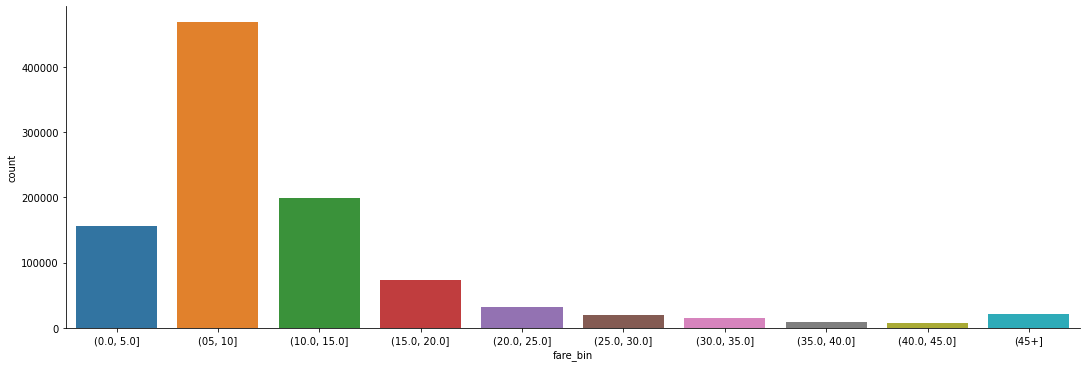

In [7]:
# create bins for fare amount
bins = [x for x in range(0, 50, 5)]
df['fare_bin'] = pd.cut(df.fare_amount, bins=bins).astype('str')
# adjust fare_bin and sort by fare_bin
df.loc[df.fare_bin=='(5.0, 10.0]', 'fare_bin'] = '(05, 10]'
df.loc[df.fare_bin=='nan', 'fare_bin'] = '(45+]'
df.sort_values('fare_bin', inplace=True)
# plot
sns.catplot(data=df, x='fare_bin', kind='count', height=5, aspect=3);

## Feature exploration and engineering

- let's first checkout which features are there and what are the datatypes

In [8]:
# check data types
df.drop(columns=['fare_amount', 'key', 'fare_bin']).dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Time features

- let's first extract some features from pickup_datetime

In [9]:
df.pickup_datetime.isnull().sum()

0

In [10]:
# extract time features
def get_time_features(df):
    df.index = pd.to_datetime(df.pickup_datetime.str.replace(' UTC', ''), format='%Y-%m-%d %H:%M:%S')
    df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')
    # year feature
    df['year'] = df.index.year
    # month features
    df['month'] = df.index.month
    # weekday feature
    df['weekday'] = df.index.weekday
    # hour and minute features
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    return df.reset_index(drop=True)

df = get_time_features(df)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_bin,year,month,weekday,hour,minute
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,"(0.0, 5.0]",2009,6,0,13,26
1,2010-02-13 02:22:15.0000006,4.5,2010-02-13 02:22:15 UTC,-73.995530,40.744140,-74.000129,40.734766,1,"(0.0, 5.0]",2010,2,4,21,22
2,2011-03-25 19:17:57.0000004,4.1,2011-03-25 19:17:57 UTC,-73.955227,40.764276,-73.963834,40.761401,1,"(0.0, 5.0]",2011,3,4,15,17
3,2011-10-05 06:16:00.00000029,4.9,2011-10-05 06:16:00 UTC,-73.996563,40.743817,-73.987188,40.750105,3,"(0.0, 5.0]",2011,10,2,2,16
4,2010-01-15 17:13:00.000000142,4.9,2010-01-15 17:13:00 UTC,-73.960937,40.761060,-73.960550,40.768838,1,"(0.0, 5.0]",2010,1,4,12,13


In [11]:
df[['year', 'month', 'weekday','hour', 'minute']].describe()

,year,month,weekday,hour,minute
count,999895.000000,999895.000000,999895.000000,999895.000000,999895.000000
mean,2011.740295,6.271742,2.983666,11.815043,29.566481
std,1.860625,3.436792,1.906162,5.837209,17.322609
min,2008.000000,1.000000,0.000000,0.000000,0.000000
25%,2010.000000,3.000000,1.000000,7.000000,15.000000
50%,2012.000000,6.000000,3.000000,12.000000,30.000000
75%,2013.000000,9.000000,5.000000,17.000000,45.000000
max,2015.000000,12.000000,6.000000,23.000000,59.000000


### Distances

- let's check out the pickup and droppff locations

In [12]:
df[['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,999895.000000,999895.000000,999885.000000,999885.000000
mean,-72.527086,39.929247,-72.528678,39.920393
std,12.056817,7.625714,11.322061,8.200581
min,-3377.680935,-3116.285383,-3383.296608,-3114.338567
25%,-73.992060,40.734967,-73.991385,40.734047
50%,-73.981793,40.752695,-73.980136,40.753166
75%,-73.967097,40.767153,-73.963655,40.768127
max,2522.271325,2621.628430,45.581619,1651.553433


In [13]:
df.shape

(999895, 14)

- According to [StateBoundaries.sql](https://gist.github.com/jakebathman/719e8416191ba14bb6e700fc2d5fccc5), NYC latitude is between(40.4772,45.0153) and longitude is between (-79.7624,-71.7517)

In [14]:
def lat_long_clean(df):
    df = df[df.pickup_longitude.between(-79.7624,-71.7517)]
    df = df[df.pickup_latitude.between(40.4772,45.0153)]
    df = df[df.dropoff_longitude.between(-79.7624,-71.7517)]
    df = df[df.dropoff_latitude.between(40.4772,45.0153)]
    return df

In [15]:
df = lat_long_clean(df)
df.shape

(979094, 14)

In [16]:
df[['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,979094.000000,979094.000000,979094.000000,979094.000000
mean,-73.975219,40.751127,-73.974305,40.751467
std,0.041278,0.030033,0.039771,0.033439
min,-78.669423,40.479777,-78.669423,40.478964
25%,-73.992272,40.736580,-73.991573,40.735590
50%,-73.982084,40.753417,-73.980593,40.753875
75%,-73.968316,40.767583,-73.965326,40.768420
max,-72.702870,43.213962,-72.694838,44.600000


There are several ways of calculating the distance between pickup and dropoff locations:
- Haversine Distance determines the great-circle distance between two points on a sphere given their longitudes and latitudes
- Googlemap distances that can be request from google distance matrix api using pickup and dropoff coordinates
- Manhattan Distance is the sum of the horizontal and vertical distances between points on a grid

#### Haversine distance

Here is the function for calculating haversine distance: 
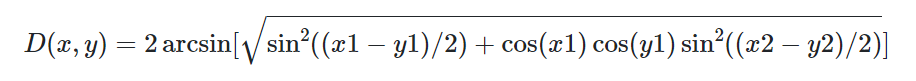
x, y represent the two points on the surface of a sphere; 1 and 2 represent latitude and longtitude, respectively.

In [17]:
# calculate haversine distance
def haversine_distance(df, lat1, lng1, lat2, lng2):
    lng1 = np.radians(df[lng1])
    lng2 = np.radians(df[lng2])
    lat1 = np.radians(df[lat1])
    lat2 = np.radians(df[lat2])
    lng_dist = lng2 - lng1
    lat_dist = lat2 - lat1
    a = (np.sin(lat_dist / 2.0)) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(lng_dist / 2.0)) ** 2
    haversine_distance = 6371000 * 2 * np.arcsin(np.sqrt(a))
    return haversine_distance

df['haversine_distance'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [18]:
df.haversine_distance.describe()

count    979094.000000
mean       3335.717840
std        3938.362774
min           0.000000
25%        1253.963766
50%        2152.608358
75%        3917.529280
max      424833.107004
Name: haversine_distance, dtype: float64

#### manhattan distance

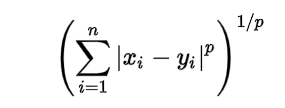
p = 1, Manhattan Distance                        
p = 2, Euclidean Distance                                

- Considering our complete training dataset contains 55 million entries and using google distance matrix is a very expensive approach, I will also consider using manhattan distance.         
- Manhattan distance is the sum of the horizontal and vertical distances between points on a grid. It suits better than haversine distance to our problem as taxi drives on the street.

In [19]:
# define a function for getting Manhattan Distance
def manhattan_distance(x1, x2, y1, y2):
    return abs(x2 - x1) + abs(y2 - y1)

In [20]:
# add manhattan distance to the dataset
df['manhattan_distance'] = manhattan_distance(df.pickup_latitude, 
                                              df.dropoff_latitude, 
                                              df.pickup_longitude, 
                                              df.dropoff_longitude)

#### googlemap distance

- Compare to haversine distance, googlemap driving distance might be more correlated with fare amount. Let's check that out.
- Due to the limited free calls from googlemap distance matrix, I will request the distances for the first 20k entries and used that for exploration.

In [21]:
tmp = df.iloc[:20000, :]
# from distance matrix API request the distance 
'''
import googlemaps 

# instantiate googlemaps client
API_key = ''
gmaps = googlemaps.Client(key=API_key)

# create pickup and dropoff columns for API request
tmp['pickup'] = tmp.pickup_latitude.astype('str')+','+tmp.pickup_longitude.astype('str')
tmp['dropoff'] = tmp.dropoff_latitude.astype('str')+','+tmp.dropoff_longitude.astype('str')

# create googlemap_distance column
tmp['googlemap_distance'] = 0

# reset index 
tmp = tmp.reset_index(drop=True)

# iterrate over each row to request googlemap distance
for i in range(len(tmp)):
    print(f'getting distance for row number.{i}')
    try:
        result = gmaps.distance_matrix(tmp.loc[i,'pickup'], tmp.loc[i,'dropoff'], mode='driving')
        distance = result["rows"][0]["elements"][0]["distance"]["value"]
    except:
        print('except')
        distance = np.nan
    tmp.loc[i, 'googlemap_distance'] = distance 
'''
# save this dataframe as csv
'''
tmp = tmp.set_index('key')
tmp.to_csv('../NYCtaxifarePredictor/data/train_20k.csv')
'''
# upload this data to google cloud storage
'''
from google.cloud import storage
client = storage.Client()
bucket = client.bucket('nyc_taxifare_predictor')
blob = bucket.blob('data/train_20k.csv')
blob.upload_from_filename('../NYCtaxifarePredictor/data/train_20k.csv')
'''
print('Data has been requested and stored in local, read the csv from local')

Data has been requested and stored in local, read the csv from local


In [22]:
tmp = pd.read_csv('../NYCtaxifarePredictor/data/train_20k.csv')
tmp

,key,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_bin,year,...,dayofweek_cos,month_cos,hour_sin,dayofweek_sin,month_sin,haversine_distance,pickup,dropoff,googlemap_distance,manhattan_distance
0,2009-06-15 17:26:21.0000001,2009-06-15 13:26:21-04:00,4.50,-73.844311,40.721319,-73.841610,40.712278,1,"(0.0, 5.0]",2009,...,1.0,-0.959493,-0.398401,0.000000e+00,-2.817326e-01,1030.763935,"40.721319,-73.844311","40.712278000000005,-73.84161",1375.0,0.011742
1,2012-03-04 19:57:42.0000003,2012-03-04 14:57:42-05:00,4.50,-74.005936,40.717622,-74.002777,40.728687,1,"(0.0, 5.0]",2012,...,1.0,-0.142315,-0.631088,-2.449294e-16,9.898214e-01,1258.842500,"40.717622,-74.005936","40.728687,-74.00277700000001",1279.0,0.014224
2,2013-09-05 15:12:22.0000003,2013-09-05 11:12:22-04:00,5.00,-73.962893,40.766498,-73.970161,40.759770,1,"(0.0, 5.0]",2013,...,-1.0,0.415415,0.136167,1.224647e-16,-9.096320e-01,966.627729,"40.766498,-73.96289300000001","40.75977,-73.970161",1138.0,0.013996
3,2012-09-09 18:53:16.0000002,2012-09-09 14:53:16-04:00,5.00,-73.993648,40.762107,-73.984362,40.774005,2,"(0.0, 5.0]",2012,...,1.0,0.415415,-0.631088,-2.449294e-16,-9.096320e-01,1536.837837,"40.762107,-73.993648","40.774004999999995,-73.984362",1576.0,0.021184
4,2011-03-20 12:19:59.0000002,2011-03-20 08:19:59-04:00,4.10,-73.984642,40.761899,-73.977182,40.764339,1,"(0.0, 5.0]",2011,...,1.0,-0.142315,0.816970,-2.449294e-16,9.898214e-01,684.365814,"40.761899,-73.98464200000001","40.764339,-73.977182",984.0,0.009900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19567,2013-11-07 08:41:00.00000035,2013-11-07 03:41:00-05:00,52.00,-73.790760,40.646777,-73.993680,40.731962,1,(45+],2013,...,-1.0,1.000000,0.730836,1.224647e-16,-1.133108e-15,19556.070714,"40.646777,-73.79075999999999","40.731962,-73.99368",29491.0,0.288105
19568,2009-08-02 23:46:00.000000115,2009-08-02 19:46:00-04:00,49.57,-73.790232,40.647485,-73.977323,40.786237,3,(45+],2009,...,1.0,-0.142315,-0.887885,-2.449294e-16,-9.898214e-01,22060.498975,"40.647484999999996,-73.79023199999999","40.786237,-73.977323",33019.0,0.325843
19569,2012-10-23 07:57:00.000000129,2012-10-23 03:57:00-04:00,56.80,-73.988152,40.740112,-73.782355,40.646727,2,(45+],2012,...,0.5,0.841254,0.730836,8.660254e-01,-5.406408e-01,20220.464172,"40.740111999999996,-73.988152","40.646727,-73.78235500000001",27825.0,0.299182
19570,2010-04-03 06:48:00.00000022,2010-04-03 02:48:00-04:00,49.57,-73.999613,40.733570,-73.786067,40.639070,2,(45+],2010,...,0.5,-0.654861,0.519584,-8.660254e-01,7.557496e-01,20847.633595,"40.73357,-73.999613","40.639070000000004,-73.786067",29171.0,0.308046


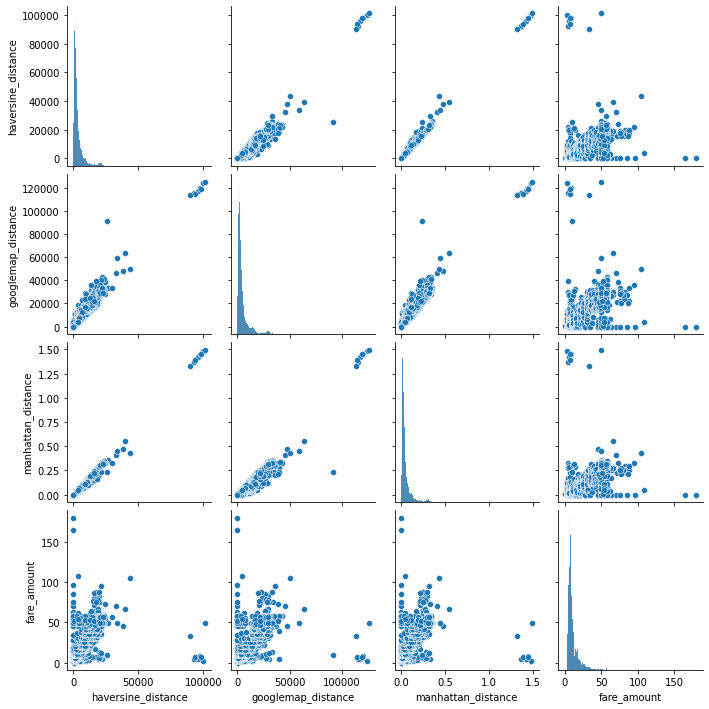

In [23]:
sns.pairplot(tmp[['haversine_distance', 'googlemap_distance', 'manhattan_distance', 'fare_amount']])

<AxesSubplot:xlabel='googlemap_distance', ylabel='fare_amount'>

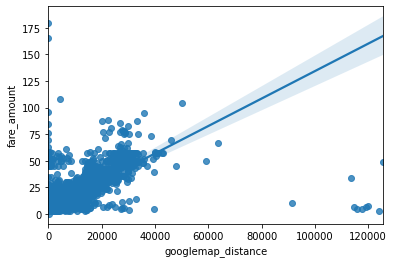

In [24]:
# googlemap_distance
sns.regplot(data=tmp, x='googlemap_distance', y='fare_amount')

<AxesSubplot:xlabel='manhattan_distance', ylabel='fare_amount'>

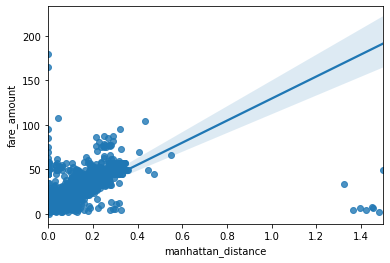

In [25]:
# manhattan distance
sns.regplot(data=tmp, x='manhattan_distance', y='fare_amount')

<AxesSubplot:xlabel='haversine_distance', ylabel='fare_amount'>

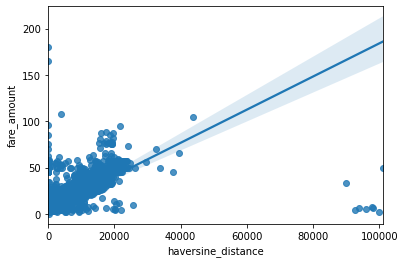

In [26]:
# haversine distance
sns.regplot(data=tmp, x='haversine_distance', y='fare_amount')

In [27]:
tmp[['haversine_distance', 'googlemap_distance', 'manhattan_distance', 'fare_amount']].corr()

,haversine_distance,googlemap_distance,manhattan_distance,fare_amount
haversine_distance,1.000000,0.974900,0.992433,0.762963
googlemap_distance,0.974900,1.000000,0.965297,0.790440
manhattan_distance,0.992433,0.965297,1.000000,0.749465
fare_amount,0.762963,0.790440,0.749465,1.000000


- As expected googlemap distance has the highest correlation with fare amount. However, getting googlemap distance is expensive and time consuming. I will keep working with haversine distance.

### passenger

- according to [NYC Taxi & Limousine Commission](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page), there is no charge for extra passengers, luggage or bags, or paying by credit car. Therefore, I will drop the passenger column.

In [28]:
df = df.drop('passenger_count', axis=1)

## Further exploration and data cleaning

### Trips with missing distance

In [29]:
# let's checkout the missing values for distance
df[['haversine_distance', 'manhattan_distance']].isnull().sum()

haversine_distance    0
manhattan_distance    0
dtype: int64

### Trips with the same pickup and dropoff locations

In [30]:
df['pickup'] = df.pickup_latitude.astype('str')+','+df.pickup_longitude.astype('str')
df['dropoff'] = df.dropoff_latitude.astype('str')+','+df.dropoff_longitude.astype('str')
df[df.pickup==df.dropoff]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_bin,year,month,weekday,hour,minute,haversine_distance,manhattan_distance,pickup,dropoff
28,2013-09-29 17:57:03.0000004,2.50,2013-09-29 17:57:03 UTC,-73.947096,40.779991,-73.947096,40.779991,"(0.0, 5.0]",2013,9,6,13,57,0.0,0.0,"40.779990999999995,-73.947096","40.779990999999995,-73.947096"
134,2012-12-20 10:58:46.0000005,2.50,2012-12-20 10:58:46 UTC,-73.907140,40.890797,-73.907140,40.890797,"(0.0, 5.0]",2012,12,3,5,58,0.0,0.0,"40.890797,-73.90714","40.890797,-73.90714"
171,2012-05-05 16:14:00.00000091,4.90,2012-05-05 16:14:00 UTC,-73.987387,40.738762,-73.987387,40.738762,"(0.0, 5.0]",2012,5,5,12,14,0.0,0.0,"40.738762,-73.987387","40.738762,-73.987387"
177,2009-04-01 18:53:00.00000082,4.50,2009-04-01 18:53:00 UTC,-74.010688,40.722895,-74.010688,40.722895,"(0.0, 5.0]",2009,4,2,14,53,0.0,0.0,"40.722895,-74.010688","40.722895,-74.010688"
261,2014-05-22 11:43:18.0000002,4.50,2014-05-22 11:43:18 UTC,-73.986068,40.762381,-73.986068,40.762381,"(0.0, 5.0]",2014,5,3,7,43,0.0,0.0,"40.762381,-73.986068","40.762381,-73.986068"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999733,2015-06-05 06:33:20.0000002,100.00,2015-06-05 06:33:20 UTC,-74.177055,40.695023,-74.177055,40.695023,(45+],2015,6,4,2,33,0.0,0.0,"40.69502258300781,-74.17705535888672","40.69502258300781,-74.17705535888672"
999746,2012-11-21 16:15:00.00000082,130.00,2012-11-21 16:15:00 UTC,-73.789943,40.643583,-73.789943,40.643583,(45+],2012,11,2,11,15,0.0,0.0,"40.643583,-73.78994300000001","40.643583,-73.78994300000001"
999791,2009-09-17 16:36:00.00000021,49.57,2009-09-17 16:36:00 UTC,-74.001908,40.761490,-74.001908,40.761490,(45+],2009,9,3,12,36,0.0,0.0,"40.76149,-74.001908","40.76149,-74.001908"
999822,2009-04-30 19:25:15.0000003,80.00,2009-04-30 19:25:15 UTC,-73.424131,40.731507,-73.424131,40.731507,(45+],2009,4,3,15,25,0.0,0.0,"40.731507,-73.424131","40.731507,-73.424131"


In [31]:
# dropping trips with pickup == dropoff
df = df[~(df.pickup==df.dropoff)]

### Trips with distance shorter than 200 meters

In [32]:
# let's check out the statistic of haversine distance
df.haversine_distance.describe()

count    968607.000000
mean       3371.833286
std        3944.218396
min           0.083916
25%        1278.615581
50%        2177.017528
75%        3949.181886
max      424833.107004
Name: haversine_distance, dtype: float64

(0.0, 20000.0)

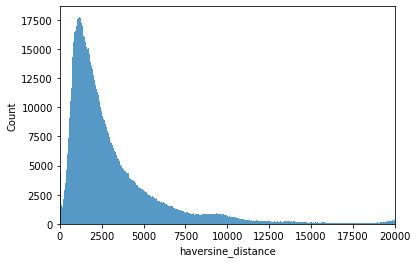

In [33]:
# let's check out distribution of haversine distance
sns.histplot(df.haversine_distance)
plt.xlim(0,20000)

In [34]:
# let's checkout the trips with haversine distance < 200
df[df.haversine_distance < 200].fare_amount.describe()

count    8570.000000
mean       13.142707
std        20.058576
min         0.010000
25%         2.500000
50%         4.500000
75%        11.700000
max       200.000000
Name: fare_amount, dtype: float64

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

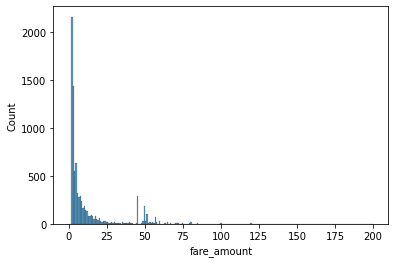

In [35]:
# let's checkout the trips with haversine distance < 200
sns.histplot(df[df.haversine_distance < 200].fare_amount)

- With distance=0, the taxi fare amount in this data set ranges from 2.5 to 180 US dollars. 
- According to [NYC Taxi & Limousine Commission](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page), the initial charge is 2.5 US dollars. Plus 50 cents per 1/5 mile (~320 meters) when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
- The fare amounts higher than 2.5 are likely caused by waiting time or wrongly recorded pickup/dropoff locations ect. These are unusual situations. 
- For predicting taxifare, waiting times before the journey shouldn't be considered.
- Considering above facts, I will put 2.5 US dollars as fare amount for the trips which have googlemap_distance <= 200

In [36]:
df.loc[df.haversine_distance<= 200, 'fare_amount'] = 2.5
df[df.haversine_distance<= 200].fare_amount.describe()

count    8570.0
mean        2.5
std         0.0
min         2.5
25%         2.5
50%         2.5
75%         2.5
max         2.5
Name: fare_amount, dtype: float64

### Trips with fare amount < 2.5

- let's drop unrealistic fare_amount

In [37]:
df = df[df.fare_amount >= 2.5]
df.shape

(968603, 17)

### Trips outside the NYC

- To remove the trips that are happend outside of NYC, I will engineer two new features that show the distance of pickup/dropoff location from NYC center

In [38]:
# Let's compute distance from NYC center
df['nyc_lat'] = 40.7128
df['nyc_lon'] = -74.0060
df['pickup_to_center'] = \
    haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'nyc_lat', 'nyc_lon')
df['dropoff_to_center'] = \
    haversine_distance(df, 'dropoff_latitude', 'dropoff_longitude', 'nyc_lat', 'nyc_lon')
df.drop(columns=['nyc_lat', 'nyc_lon'], inplace=True)

<AxesSubplot:xlabel='pickup_to_center', ylabel='dropoff_to_center'>

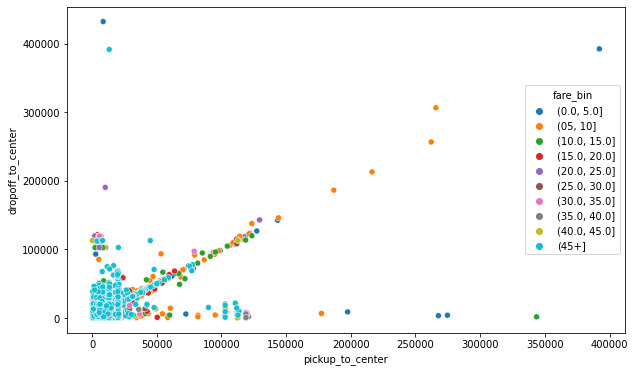

In [39]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df,
                x='pickup_to_center',
                y='dropoff_to_center',
                hue='fare_bin',
                legend='brief')

**Something interesting appearing here. What are those pickup and dropoff locations that are 30km away from the NYC center?**

- let's first checkout trips with pickup_to_center > 30 km or dropoff_to_center > 30 km

In [40]:
import folium
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=10)

In [41]:
# the trips with pickup_to_center > 30000
tmp = df[(df.pickup_to_center > 30000)]
tmp = tmp.reset_index(drop=True)
for i in range(len(tmp)):
    pickup = [tmp.pickup_latitude[i], tmp.pickup_longitude[i]]
    folium.Marker(location=pickup, icon = folium.Icon(color='red')).add_to(m)
m

In [42]:
# the trips with dropoff_to_center > 30000
tmp = df[df.dropoff_to_center > 30000]
tmp = tmp.reset_index(drop=True)
for i in range(len(tmp)):
    dropoff = [tmp.dropoff_latitude[i], tmp.dropoff_longitude[i]]
    folium.Marker(location=dropoff, icon = folium.Icon(color='blue')).add_to(m)
m

- As it shown on the map, these pickup/dropoff locations are confirmed to be outside of NYC. I will drop them.

<AxesSubplot:xlabel='pickup_to_center', ylabel='dropoff_to_center'>

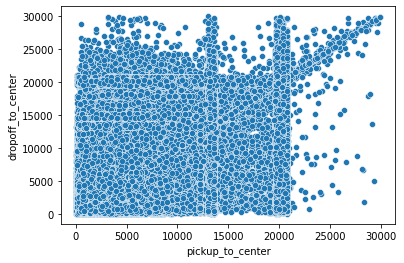

In [43]:
# dropping trips with pickup_to_center > 30000 or dropoff_to_center > 30000
df = df[(df.pickup_to_center < 30000) & (df.dropoff_to_center < 30000)]
sns.scatterplot(data=df,
                x='pickup_to_center',
                y='dropoff_to_center')

### Trips to airports

- As shown above, there are two interesting clusters we haven't explored:                           
cluster-1: pickup/dropoff_to_center in range(18km, 22km)                      
cluster-2: pickup/dropoff_to_center in range(12.5km, 13.5km)

<AxesSubplot:xlabel='pickup_to_center', ylabel='dropoff_to_center'>

c:\users\guli\.venvs\nyc_taxifare\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


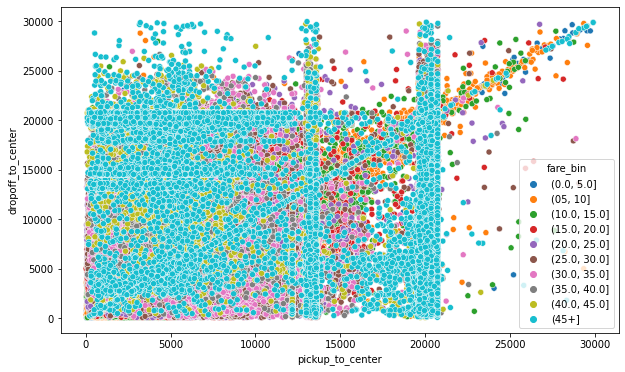

In [44]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df,
                x='pickup_to_center',
                y='dropoff_to_center',
                hue='fare_bin',
                legend='brief')

#### JFK trips

**Cluster-1 :Trips with pickup_to_center in range(18 km, 22 km)**

In [45]:
import folium
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=10)
folium.Marker(location=nyc_center, icon = folium.Icon(color='green')).add_to(m)

In [46]:
tmp = df[df.pickup_to_center.between(18000, 22000)].sample(n=200)
tmp = tmp.reset_index(drop=True)
for i in range(len(tmp)):
    dropoff = [tmp.pickup_latitude[i], tmp.pickup_longitude[i]]
    folium.Marker(location=dropoff, icon = folium.Icon(color='red')).add_to(m)
m

As shown on the map, most of these trips started from JFK airport.                        
Therefore, I will add a categorical feature (trip) to the data to specify whether that trip is from/to airport

In [47]:
df['trip'] = np.nan
jfk_lat = (40.618704303682776, 40.67697702311703)
jfk_lon = (-73.83311505102023, -73.74039257564282)
idx_1 = df.pickup_latitude.between(jfk_lat[0], jfk_lat[1]) & df.pickup_longitude.between(jfk_lon[0], jfk_lon[1])
idx_2 = df.dropoff_latitude.between(jfk_lat[0], jfk_lat[1]) & df.dropoff_longitude.between(jfk_lon[0], jfk_lon[1])
df.loc[(idx_1|idx_2), 'trip'] = 'JFK'

In [48]:
df[['trip']].value_counts()

trip
JFK     21269
dtype: int64

#### LGA trips

**Cluster-2: trips with pickup_to_center in range(12.5 km, 13.5 km)**

In [49]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_bin,year,month,weekday,hour,minute,haversine_distance,manhattan_distance,pickup,dropoff,pickup_to_center,dropoff_to_center,trip
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,"(0.0, 5.0]",2009,6,0,13,26,1030.763935,0.011742,"40.721319,-73.844311","40.712278000000005,-73.84161",13659.885873,13855.701328,NaN
1,2010-02-13 02:22:15.0000006,4.5,2010-02-13 02:22:15 UTC,-73.995530,40.744140,-74.000129,40.734766,"(0.0, 5.0]",2010,2,4,21,22,1112.028605,0.013973,"40.74414,-73.99553","40.734766,-74.000129",3594.793339,2492.112415,NaN
2,2011-03-25 19:17:57.0000004,4.1,2011-03-25 19:17:57 UTC,-73.955227,40.764276,-73.963834,40.761401,"(0.0, 5.0]",2011,3,4,15,17,792.253712,0.011482,"40.764276,-73.95522700000001","40.761401,-73.96383399999999",7145.739119,6467.339266,NaN
3,2011-10-05 06:16:00.00000029,4.9,2011-10-05 06:16:00 UTC,-73.996563,40.743817,-73.987188,40.750105,"(0.0, 5.0]",2011,10,2,2,16,1054.796256,0.015663,"40.743817,-73.996563","40.750105,-73.987188",3539.420001,4440.669605,NaN
4,2010-01-15 17:13:00.000000142,4.9,2010-01-15 17:13:00 UTC,-73.960937,40.761060,-73.960550,40.768838,"(0.0, 5.0]",2010,1,4,12,13,865.488042,0.008165,"40.76106,-73.960937","40.768838,-73.96055",6573.584899,7313.635178,NaN


In [50]:
import folium
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=11)
folium.Marker(location=nyc_center, icon = folium.Icon(color='green')).add_to(m)

In [52]:
# the trips with pickup_to_center in range(12.5 km, 13.5 km)
tmp = df[df.pickup_to_center.between(12500, 13500)].sample(n=300)
tmp = tmp.reset_index(drop=True)
for i in range(len(tmp)):
    pickup = [tmp.pickup_latitude[i], tmp.pickup_longitude[i]]
    folium.Marker(location=pickup, icon = folium.Icon(color='blue')).add_to(m)
m

- Here we see those locations spread around the NYC center
- Most of these trips actually started from LGA airport and Harlem
- I will add LGA airport to the trip column just like what I did with JFK airport.

In [53]:
# LGA locations
lga_lat = (40.76187641747602, 40.77769837144583)
lga_lon = (-73.88909476689257, -73.85813813929943)
idx_1 = df.pickup_latitude.between(lga_lat[0], lga_lat[1]) & df.pickup_longitude.between(lga_lon[0], lga_lon[1])
idx_2 = df.dropoff_latitude.between(lga_lat[0], lga_lat[1]) & df.dropoff_longitude.between(lga_lon[0], lga_lon[1])
df.loc[(idx_1|idx_2), 'trip'] = 'LGA'

In [54]:
df[['trip']].value_counts()

trip
LGA     32058
JFK     20761
dtype: int64

#### EWR trips
I will also do the same with trips that are involving EWR airport 

In [55]:
# EWR locations
ewr_lat = (40.656459243540475, 40.715695425611585)
ewr_lon = (-74.20784161826906, -74.14794832117698)
idx_1 = df.pickup_latitude.between(ewr_lat[0], ewr_lat[1]) & df.pickup_longitude.between(ewr_lon[0], ewr_lon[1])
idx_2 = df.dropoff_latitude.between(ewr_lat[0], ewr_lat[1]) & df.dropoff_longitude.between(ewr_lon[0], ewr_lon[1])
df.loc[(idx_1|idx_2), 'trip'] = 'EWR'

df[['trip']].value_counts()

trip
LGA     32041
JFK     20750
EWR      1301
dtype: int64

In [56]:
df.loc[df.trip.isnull(), 'trip'] = 'without_airport'

<AxesSubplot:xlabel='pickup_to_center', ylabel='dropoff_to_center'>

c:\users\guli\.venvs\nyc_taxifare\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


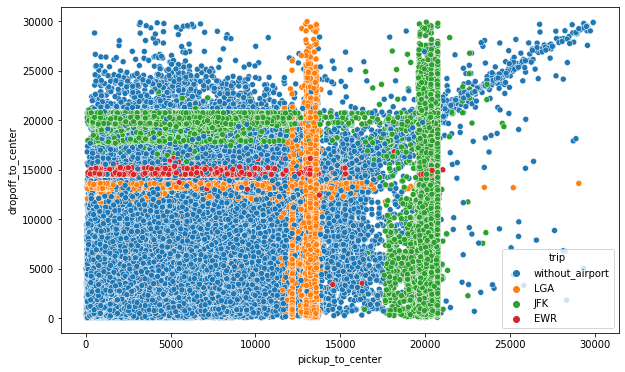

In [57]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df,
                x='pickup_to_center',
                y='dropoff_to_center',
                hue='trip',
                legend='brief')

Now, I am slightly happier :)

### Target and distances

Now, let's checkout whether there are some trips that have unusual taxi fare.

<AxesSubplot:xlabel='haversine_distance', ylabel='fare_amount'>

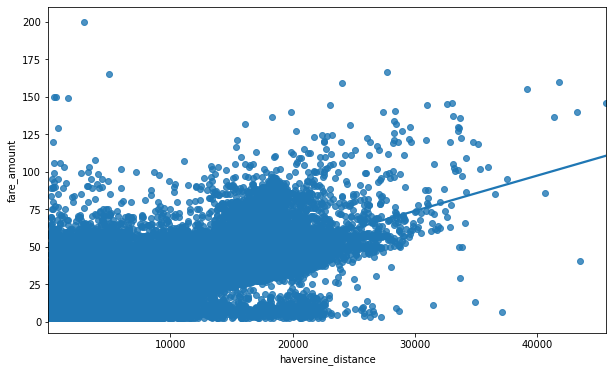

In [58]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, y='fare_amount', x='haversine_distance')

As shown in above plot, fare amount and distance has linear correlation. However, there are three isolated clusters needs our attentions.                
- cluster-1: trips with travel distance between (15000, 25000) and fare amount < 20.   
- cluster-2: trips with travel distance < 1000 and fare amount > 50.  
- cluster-3: trips with travel distance between (15000, 25000) and fare amount > 75.  

Let's check out whether those trips related to the airports

<AxesSubplot:xlabel='haversine_distance', ylabel='fare_amount'>

c:\users\guli\.venvs\nyc_taxifare\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


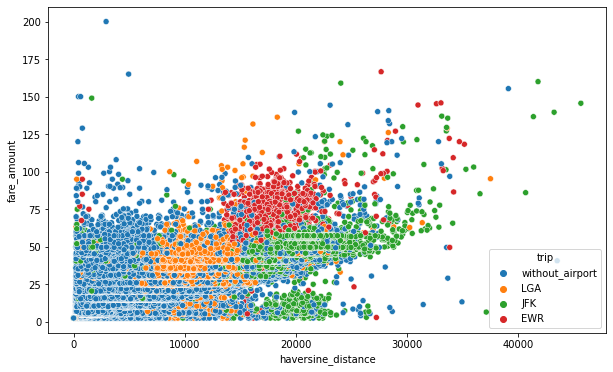

In [59]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='haversine_distance', y='fare_amount', hue='trip')

- most of cluster-1 trips involving JFK airport
- most of cluster-3 trips involving EWR airport

**what about cluster-2 ?** 
- They are most likely the trips that experienced traffic jam
- Datetime features, pickuplocation, and direction should help to capture them

### Trips with traffic 

Now, let's look at the cluster-2 trips on the map

In [60]:
import folium
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=12)

In [61]:
# sampling from cluster-2
tmp = df[df.trip=='without_airport']
tmp = tmp[(tmp.haversine_distance < 10000) & (tmp.fare_amount > 50)].sample(n=100)
tmp = tmp.reset_index(drop=True)
# pickup locations of cluster-2
for i in range(len(tmp)):
    pickup = [tmp.pickup_latitude[i], tmp.pickup_longitude[i]]
    folium.Marker(location=pickup, icon = folium.Icon(color='green')).add_to(m)
# travel path of cluster-2
for i in range(len(tmp)):
    loc = [(tmp.pickup_latitude[i], tmp.pickup_longitude[i]), (tmp.dropoff_latitude[i], tmp.dropoff_longitude[i])]
    folium.PolyLine(loc,
                color='red',
                weight=3,
                opacity=0.8).add_to(m)
m

-- green labels: pickup locations                              
-- red lines: travel directions                     

Some interesting facts about the trips in cluster-2:
- pickup locations are mostly in manhattan district 
- travel directions are mostly to the west     

#### Pickup locations

I will create a column ('pickup_location') where:                             
1. the values = 'manhattan', when pickup location was in MH 
2. the values = 'west', when pickup location was on the west of MH
3. the values = 'east', when pickup location was on the east of MH                         

In [62]:
df['pickup_location'] = 'manhattan'
# pickup  
idx_east = df.pickup_longitude > -73.929517748444
idx_west = df.pickup_longitude < -74.03226015454312
df.loc[idx_east ,'pickup_location'] = 'east' 
df.loc[idx_west ,'pickup_location'] = 'west'

df[['pickup_location']].value_counts()

pickup_location
manhattan          922371
east                44757
west                  760
dtype: int64

In [63]:
import folium
nyc_center = [40.7128, -74.0060]
m = folium.Map(location=nyc_center, zoom_start=12)

In [64]:
# pickup west
tmp = df[df.pickup_location=='west'].sample(n=100)
tmp = tmp.reset_index(drop=True)
for i in range(len(tmp)):
    pickup = [tmp.pickup_latitude[i], tmp.pickup_longitude[i]]
    folium.Marker(location=pickup, icon = folium.Icon(color='blue')).add_to(m)
# pickup east
tmp = df[df.pickup_location=='east'].sample(n=100)
tmp = tmp.reset_index(drop=True)
for i in range(len(tmp)):
    pickup = [tmp.pickup_latitude[i], tmp.pickup_longitude[i]]
    folium.Marker(location=pickup, icon = folium.Icon(color='green')).add_to(m)
# pickup manhattan
tmp = df[df.pickup_location=='manhattan'].sample(n=100)
tmp = tmp.reset_index(drop=True)
for i in range(len(tmp)):
    pickup = [tmp.pickup_latitude[i], tmp.pickup_longitude[i]]
    folium.Marker(location=pickup, icon = folium.Icon(color='red')).add_to(m)
m

- west, manhattan, east split is not perfect yet, but it should be helpful.

<Figure size 720x432 with 0 Axes>

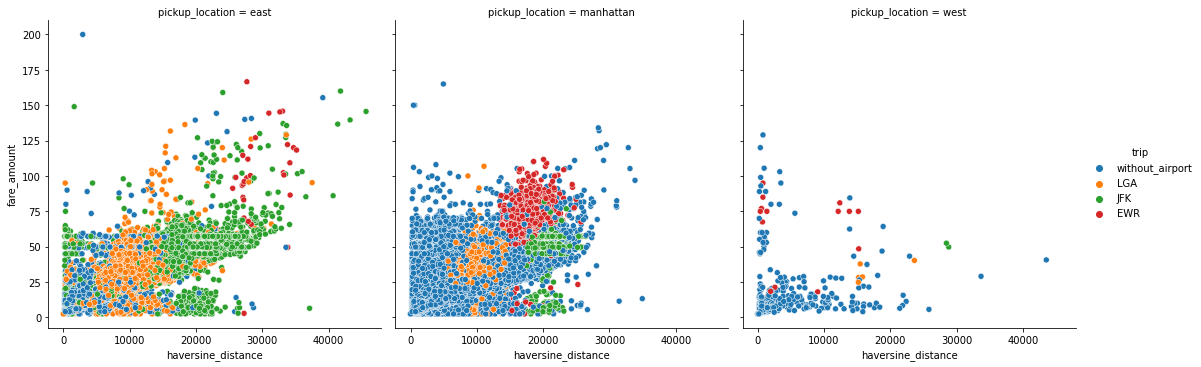

In [73]:
plt.figure(figsize=(10,6))
sns.relplot(data=df, 
            x='haversine_distance', 
            y='fare_amount', 
            hue='trip',
            col='pickup_location')

- As shown above, cluster-2 trips are highly related to pickup location not being east

#### Travel directions

The formula for calculating direction (β) based on coordinates of two locations A(lat1, lon1) and B(lat2, lon2):                 
- delta_lon = lon2 - lon1                                    
- X =  cos(lat2) * sin(delta_lon)                                                
- Y = cos(lat1) * sin(lat2) – sin(lat1) * cos(lat2) * cos(delta_lon)                     
- β = atan2(X,Y) = 1.684463062558 radians                       

In [66]:
def get_direction(lat_1, lat_2, lon_1, lon_2):
    delta_lon = lon_2-lon_1
    a = np.cos(lat_2)*np.sin(delta_lon)
    b = np.cos(lat_1)*np.sin(lat_2)-np.sin(lat_1)*np.cos(lat_2)*np.cos(delta_lon)
    direction = np.arctan2(a, b)   
    return direction

df['direction'] = get_direction(df.pickup_latitude, 
                                df.dropoff_latitude, 
                                df.pickup_longitude, 
                                df.dropoff_longitude)
df.direction.describe()

count    967888.000000
mean          0.265283
std           1.797835
min          -3.141593
25%          -1.025272
50%          -0.163930
75%           2.130455
max           3.141563
Name: direction, dtype: float64

In [67]:
# create bins for travel direction
bins = [x for x in np.arange(-np.pi, np.pi+1, np.pi)]
df['direction_bin'] = pd.cut(df.direction, bins=bins)
df[['direction_bin']].value_counts()

direction_bin
(-3.142, 0.0]    506581
(0.0, 3.142]     461212
dtype: int64

<Figure size 720x432 with 0 Axes>

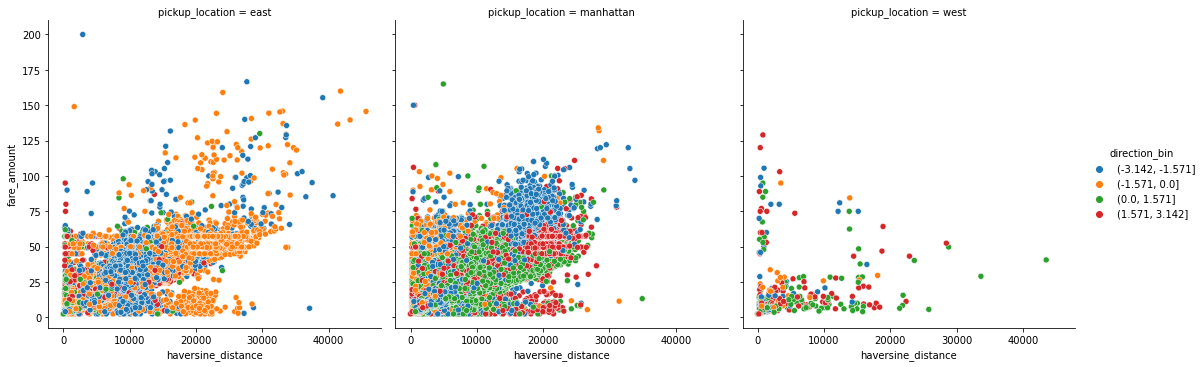

In [79]:
plt.figure(figsize=(10,6))
sns.relplot(data=df, 
            x='haversine_distance', 
            y='fare_amount', 
            hue='direction_bin',
            col='pickup_location')

Here you go!               

Now I know that cluster-2 are caused by two factors: pickup from manhattan and travel direction within (0, 3.14 radians)

Now, one more thing, the travel direction is a cyclical feature, meaning direction= - 3.1 actually is very close to the direction= 3.1. Sine/cosine transformation of direction and addition of time/location features should allow us to capture cluster-2.                    

## Train/Validation  split

Let's split the data into train and validation sets.           
- Train set will be used for training and validation set will be used for evaluating model performance. 
- By comparing performance (R-squared and RMSE) of different models on the same validation set, I will select best performed model for large scale training.

In [49]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.1, random_state=5)
train = train.copy()
val = val.copy()

## Data preprocessing

Here, I will define a function to engineer features and clean the data. The content of function is based on what I did before.

In [50]:
%%time
def feature_engineer(df, test=False):
    # extract time features
    df.index = pd.to_datetime(df.pickup_datetime.str.replace(' UTC', ''), format='%Y-%m-%d %H:%M:%S')
    df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')
    df['year'] = df.index.year
    # day of year   
    day = df.index.dayofyear-1
    df['dayofyear_cos'] = np.cos(np.pi*day/365)
    df['dayofyear_sin'] = np.sin(np.pi*day/365)
    # day of week
    weekday = df.index.weekday
    df['weekday_cos'] = np.cos(np.pi*weekday/6)
    df['weekday_sin'] = np.sin(np.pi*weekday/6)
    # hour 
    hour = df.index.hour
    minute = df.index.minute
    minutes = 60*hour+minute
    df['hour_cos'] = np.cos(np.pi*minutes/1440)
    df['hour_sin'] = np.sin(np.pi*minutes/1440)
    # drop pickup_datetime
    df = df.reset_index(drop=True)
    df = df.drop('pickup_datetime', axis=1)
    # drop passenger count
    df = df.drop('passenger_count', axis=1)
    # engineering haversine distance
    lon1 = np.radians(df['pickup_longitude'])
    lon2 = np.radians(df['dropoff_longitude'])
    lat1 = np.radians(df['pickup_latitude'])
    lat2 = np.radians(df['dropoff_latitude'])
    delta_lon = lon2 - lon1
    delta_lat = lat2 - lat1
    a = (np.sin(delta_lat / 2.0)) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lon / 2.0)) ** 2
    df['haversine_distance'] = 6371000 * 2 * np.arcsin(np.sqrt(a))
    # engineering direction
    a = np.cos(lat2)*np.sin(delta_lon)
    b = np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(delta_lon)
    direction = np.arctan2(a, b)
    df['direction_sin'] =np.sin(direction)
    df['direction_cos'] =np.cos(direction)
    # engineering distance to the center
    nyc_lat = np.radians(40.7128)
    nyc_lon = np.radians(-74.0060)
    delta_lon = nyc_lon - lon1
    delta_lat = nyc_lat - lat1
    a = (np.sin(delta_lat / 2.0)) ** 2 + np.cos(lat1) * np.cos(nyc_lat) * (np.sin(delta_lon / 2.0)) ** 2
    df['pickup_to_center'] = 6371000 * 2 * np.arcsin(np.sqrt(a))
    delta_lon = nyc_lon - lon2
    delta_lat = nyc_lat - lat2
    a = (np.sin(delta_lat / 2.0)) ** 2 + np.cos(lat2) * np.cos(nyc_lat) * (np.sin(delta_lon / 2.0)) ** 2
    df['dropoff_to_center'] = 6371000 * 2 * np.arcsin(np.sqrt(a))
    # engineer trips with airport involved
    df['JFK'] = 0
    jfk_lat = (40.618704303682776, 40.67697702311703)
    jfk_lon = (-73.83311505102023, -73.74039257564282)
    idx_1 = df.pickup_latitude.between(jfk_lat[0], jfk_lat[1]) & df.pickup_longitude.between(jfk_lon[0], jfk_lon[1])
    idx_2 = df.dropoff_latitude.between(jfk_lat[0], jfk_lat[1]) & df.dropoff_longitude.between(jfk_lon[0], jfk_lon[1])
    df.loc[(idx_1|idx_2), 'JFK'] = 1
    df['LGA'] = 0
    lga_lat = (40.76187641747602, 40.77769837144583)
    lga_lon = (-73.88909476689257, -73.85813813929943)
    idx_1 = df.pickup_latitude.between(lga_lat[0], lga_lat[1]) & df.pickup_longitude.between(lga_lon[0], lga_lon[1])
    idx_2 = df.dropoff_latitude.between(lga_lat[0], lga_lat[1]) & df.dropoff_longitude.between(lga_lon[0], lga_lon[1])
    df.loc[(idx_1|idx_2), 'LGA'] = 1
    df['EWR'] = 0
    ewr_lat = (40.656459243540475, 40.715695425611585)
    ewr_lon = (-74.20784161826906, -74.14794832117698)
    idx_1 = df.pickup_latitude.between(ewr_lat[0], ewr_lat[1]) & df.pickup_longitude.between(ewr_lon[0], ewr_lon[1])
    idx_2 = df.dropoff_latitude.between(ewr_lat[0], ewr_lat[1]) & df.dropoff_longitude.between(ewr_lon[0], ewr_lon[1])
    df.loc[(idx_1|idx_2), 'EWR'] = 1
    # engineering pickup locations
    df['east'] = 0
    df['west'] = 0
    idx_east = df.pickup_longitude > -73.929517748444
    idx_west = df.pickup_longitude < -74.03226015454312
    df.loc[idx_east ,'east'] = 1
    df.loc[idx_west ,'west'] = 1
    # set index to 'key' column
    df.set_index('key', inplace=True)
    return df

train = feature_engineer(train)
train.head()

Wall time: 11.7 s


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,dayofyear_cos,dayofyear_sin,weekday_cos,weekday_sin,...,haversine_distance,direction_sin,direction_cos,pickup_to_center,dropoff_to_center,JFK,LGA,EWR,east,west
key,,,,,,,,,,,,,,,,,,,,,
2012-09-08 12:07:00.0000004,5.5,-73.968340,40.761472,-73.972622,40.755767,2012,-0.556017,0.831171,-0.866025,5.000000e-01,...,729.722925,-0.494260,-0.869314,6273.634490,5543.986819,0,0,0,0,0
2012-04-10 21:53:00.00000064,6.9,-73.987135,40.739465,-74.004530,40.731997,2012,0.651899,0.758306,0.866025,5.000000e-01,...,1684.524574,-0.870101,-0.492874,3364.293886,2138.200634,0,0,0,0,0
2013-02-05 19:58:11.0000001,6.5,-73.982543,40.760103,-73.988136,40.748180,2013,0.954967,0.296713,0.866025,5.000000e-01,...,1406.993210,-0.334865,-0.942266,5618.901456,4212.215507,0,0,0,0,0
2011-10-02 05:06:00.00000014,16.1,-73.993905,40.725003,-73.950952,40.673015,2011,-0.708627,0.705584,-1.000000,1.224647e-16,...,6821.250871,0.531051,-0.847340,1697.126353,6411.740074,0,0,0,0,0
2014-03-12 08:57:14.0000002,23.0,-73.959409,40.770926,-74.015149,40.710206,2014,0.823923,0.566702,0.500000,8.660254e-01,...,8224.303009,-0.571258,-0.820770,7561.846568,823.313310,0,0,0,0,0


In [51]:
def clean_train(df):
    # drop the rows without haversine distance
    df = df[~(df.haversine_distance.isnull())]
    # dropping the trips that are not in NYC
    idx_1 = df.pickup_longitude.between(-79.7624,-71.7517) & df.pickup_latitude.between(40.4772,45.0153)
    idx_2 = df.dropoff_longitude.between(-79.7624,-71.7517) & df.dropoff_latitude.between(40.4772,45.0153)
    df = df[idx_1|idx_2]
    # trips with distance shorter than 200m
    df.loc[df.haversine_distance<= 200, 'fare_amount'] = 2.5
    # dropping trips with unrealistic fare amount
    df = df[df.fare_amount.between(2.5, 200)]
    return df

train = clean_train(train)
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,dayofyear_cos,dayofyear_sin,weekday_cos,weekday_sin,...,haversine_distance,direction_sin,direction_cos,pickup_to_center,dropoff_to_center,JFK,LGA,EWR,east,west
key,,,,,,,,,,,,,,,,,,,,,
2012-09-08 12:07:00.0000004,5.5,-73.968340,40.761472,-73.972622,40.755767,2012,-0.556017,0.831171,-0.866025,5.000000e-01,...,729.722925,-0.494260,-0.869314,6273.634490,5543.986819,0,0,0,0,0
2012-04-10 21:53:00.00000064,6.9,-73.987135,40.739465,-74.004530,40.731997,2012,0.651899,0.758306,0.866025,5.000000e-01,...,1684.524574,-0.870101,-0.492874,3364.293886,2138.200634,0,0,0,0,0
2013-02-05 19:58:11.0000001,6.5,-73.982543,40.760103,-73.988136,40.748180,2013,0.954967,0.296713,0.866025,5.000000e-01,...,1406.993210,-0.334865,-0.942266,5618.901456,4212.215507,0,0,0,0,0
2011-10-02 05:06:00.00000014,16.1,-73.993905,40.725003,-73.950952,40.673015,2011,-0.708627,0.705584,-1.000000,1.224647e-16,...,6821.250871,0.531051,-0.847340,1697.126353,6411.740074,0,0,0,0,0
2014-03-12 08:57:14.0000002,23.0,-73.959409,40.770926,-74.015149,40.710206,2014,0.823923,0.566702,0.500000,8.660254e-01,...,8224.303009,-0.571258,-0.820770,7561.846568,823.313310,0,0,0,0,0


In [6]:
from sklearn.preprocessing import StandardScaler
scaling_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                   'year', 'haversine_distance',  'pickup_to_center', 'dropoff_to_center']
scaler = StandardScaler().fit(train[scaling_columns])
train[scaling_columns] = scaler.transform(train[scaling_columns])
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,dayofyear_cos,dayofyear_sin,weekday_cos,weekday_sin,...,haversine_distance,direction_sin,direction_cos,pickup_to_center,dropoff_to_center,JFK,LGA,EWR,east,west
count,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,...,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06,1.760579e+06
mean,1.112261e+01,-5.961603e-13,-5.610156e-13,6.741308e-14,4.327226e-13,-3.140070e-14,5.686446e-02,6.373182e-01,-8.375025e-04,5.727168e-01,...,2.499561e-16,2.699235e-02,1.709284e-02,5.273480e-16,-8.067698e-16,2.211602e-02,3.255861e-02,1.396132e-03,4.698000e-02,9.956952e-04
std,9.293031e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.060063e-01,3.035578e-01,7.331002e-01,3.668232e-01,...,1.000000e+00,6.229487e-01,7.816103e-01,1.000000e+00,1.000000e+00,1.470609e-01,1.774783e-01,3.733876e-02,2.115961e-01,3.153893e-02
min,2.500000e+00,-1.096098e+01,-1.016286e+01,-1.125548e+01,-9.710793e+00,-2.006275e+00,-1.000000e+00,-3.216245e-16,-1.000000e+00,0.000000e+00,...,-9.303478e-01,-1.000000e+00,-1.000000e+00,-1.632254e+00,-1.655056e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-4.854428e-01,-5.303215e-01,-4.980273e-01,-5.085771e-01,-9.327546e-01,-6.584016e-01,3.856634e-01,-8.660254e-01,5.000000e-01,...,-5.776207e-01,-5.096367e-01,-8.361559e-01,-6.871819e-01,-6.736532e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.500000e+00,-1.905044e-01,9.261258e-02,-1.762529e-01,8.531625e-02,1.407654e-01,1.415403e-01,7.055836e-01,6.123234e-17,5.000000e-01,...,-3.250169e-01,5.374385e-02,5.046431e-02,-1.056303e-01,-1.205387e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.250000e+01,2.069369e-01,6.185427e-01,2.695449e-01,5.574976e-01,6.775254e-01,7.498264e-01,9.209713e-01,8.660254e-01,8.660254e-01,...,1.696473e-01,5.514608e-01,8.576582e-01,4.800748e-01,4.915867e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.000000e+02,9.275851e+00,8.493758e+00,9.477919e+00,7.412110e+00,1.751045e+00,1.000000e+00,9.999907e-01,1.000000e+00,1.000000e+00,...,1.232578e+01,1.000000e+00,1.000000e+00,7.248769e+00,6.986919e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Evaluation metric

The evaluation metric for this competition is the root mean-squared error or RMSE. RMSE measures the difference between the predictions of a model, and the corresponding ground truth.            
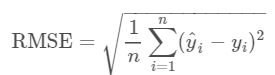

In [7]:
# let's define a function to calculate RMSE
def get_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

## Model baseline

Before start buidling the model, let's get a performance benchmark by predicting the taxifare using the average taxifare amount from the train set.

In [8]:
y_pred = train.fare_amount.mean()
rmse = get_rmse(val.fare_amount, y_pred)
rmse

9.76291854029049

## Feature selection
Here, I will use most basic LinearRegression model to decide which features to use.

### Basic features
Here, I will only include pickup and dropoff coordinates, travel direction, travel distance and time features.

In [14]:
# X and y
X = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
     'direction_sin', 'direction_cos', 'haversine_distance',
     'year', 'dayofyear_cos', 'dayofyear_sin', 'weekday_cos', 'weekday_sin', 'hour_cos','hour_sin']
y = 'fare_amount'

**Multicolinearity ?**               

Before using any linear model, let's check out whether we have multicolinearity issue. 

In [23]:
# checking multicolinearity using VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
tmp = train[X]
pd.DataFrame({'vif_index':[vif(tmp.values, i) for i in range(tmp.shape[1])],
              'feature':tmp.columns}).sort_values('vif_index', ascending=False)

,vif_index,feature
13,4.467493,hour_sin
9,4.023729,dayofyear_sin
11,2.867664,weekday_sin
3,2.306719,dropoff_latitude
1,2.217422,pickup_latitude
5,2.184547,direction_cos
0,1.874994,pickup_longitude
4,1.871958,direction_sin
2,1.806616,dropoff_longitude
6,1.476855,haversine_distance


- VIF indexes all very small, meaning there isn't multicolinearity problem

**Train and evaluate the model**

In [24]:
%%time
# LinearRegression
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()

# cross validation 
from sklearn.model_selection import cross_validate
results = cross_validate(linear_reg, 
                         train[X], 
                         train[y], 
                         cv=10, 
                         scoring=['r2', 'neg_root_mean_squared_error'],
                         return_train_score=True)
print('        r2   rmse          ')
print('test:', 
      np.round(results['test_r2'].mean(), 3), 
      -np.round(results['test_neg_root_mean_squared_error'].mean(), 3))
print('train:', 
      np.round(results['train_r2'].mean(), 3), 
      -np.round(results['train_neg_root_mean_squared_error'].mean(), 3))

        r2   rmse          
test: 0.832 3.813
train: 0.832 3.813
Wall time: 29.9 s


### Basic features + airports
Here, I will only include pickup and dropoff coordinates, travel direction, travel distance, time features and whether the trip is from/to airport.

In [25]:
# X and y
X = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
     'direction_sin', 'direction_cos', 'haversine_distance',
     'year', 'dayofyear_cos', 'dayofyear_sin', 'weekday_cos', 'weekday_sin', 'hour_cos','hour_sin',
     'EWR', 'JFK', 'LGA']
y = 'fare_amount'

In [26]:
%%time
# cross validation 
results = cross_validate(linear_reg, 
                         train[X], 
                         train[y], 
                         cv=10, 
                         scoring=['r2', 'neg_root_mean_squared_error'],
                         return_train_score=True)
print('        r2   rmse          ')
print('test:', 
      np.round(results['test_r2'].mean(), 3), 
      -np.round(results['test_neg_root_mean_squared_error'].mean(), 4))
print('train:', 
      np.round(results['train_r2'].mean(), 3), 
      -np.round(results['train_neg_root_mean_squared_error'].mean(), 4))

        r2   rmse          
test: 0.849 3.6085
train: 0.849 3.6087
Wall time: 33.3 s


RMSE is getting smaller :)

### Basic features + airports + pickup distance
Here, I will only include pickup and dropoff coordinates, travel direction, travel distance, time features, whether the trip is from/to airport and the distance of pickup to the center.

In [27]:
# X and y
X = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
     'direction_sin', 'direction_cos', 'haversine_distance',
     'year', 'dayofyear_cos', 'dayofyear_sin', 'weekday_cos', 'weekday_sin', 'hour_cos','hour_sin',
     'EWR', 'JFK', 'LGA',
     'pickup_to_center']
y = 'fare_amount'

In [28]:
%%time
# cross validation 
results = cross_validate(linear_reg, 
                         train[X], 
                         train[y], 
                         cv=10, 
                         scoring=['r2', 'neg_root_mean_squared_error'],
                         return_train_score=True)
print('        r2   rmse          ')
print('test:', 
      np.round(results['test_r2'].mean(), 3), 
      -np.round(results['test_neg_root_mean_squared_error'].mean(), 4))
print('train:', 
      np.round(results['train_r2'].mean(), 3), 
      -np.round(results['train_neg_root_mean_squared_error'].mean(), 4))

        r2   rmse          
test: 0.849 3.6067
train: 0.849 3.6068
Wall time: 34 s


RMSE is slightly smaller :)

### Basic features + airports + pickup distance + dropoff distance
Here, I will only include pickup and dropoff coordinates, travel direction, travel distance, time features, whether the trip is from/to airport and the distances of pickup and dropoff locations to the center.

In [29]:
# X and y
X = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
     'direction_sin', 'direction_cos', 'haversine_distance',
     'year', 'dayofyear_cos', 'dayofyear_sin', 'weekday_cos', 'weekday_sin', 'hour_cos','hour_sin',
     'EWR', 'JFK', 'LGA', 
     'pickup_to_center', 'dropoff_to_center']
y = 'fare_amount'

In [30]:
%%time
# cross validation 
results = cross_validate(linear_reg, 
                         train[X], 
                         train[y], 
                         cv=10, 
                         scoring=['r2', 'neg_root_mean_squared_error'],
                         return_train_score=True)
print('        r2   rmse          ')
print('test:', 
      np.round(results['test_r2'].mean(), 3), 
      -np.round(results['test_neg_root_mean_squared_error'].mean(), 4))
print('train:', 
      np.round(results['train_r2'].mean(), 3), 
      -np.round(results['train_neg_root_mean_squared_error'].mean(), 4))

        r2   rmse          
test: 0.85 3.6039
train: 0.85 3.604
Wall time: 26.5 s


RMSE is getting smaller :)

### Basic features + airports + pickup distance + dropoff distance + pickup region
Here, I will only include pickup and dropoff coordinates, travel direction, travel distance, time features, whether the trip is from/to airport, the distances of pickup and dropoff locations to the center, and the regions of pickup location belongs to.

In [31]:
# X and y
X = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
     'direction_sin', 'direction_cos', 'haversine_distance',
     'year', 'dayofyear_cos', 'dayofyear_sin', 'weekday_cos', 'weekday_sin', 'hour_cos','hour_sin',
     'EWR', 'JFK', 'LGA',
     'pickup_to_center', 'dropoff_to_center',
     'east', 'west']
y = 'fare_amount'

In [32]:
%%time
# LinearRegression
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()

# cross validation 
from sklearn.model_selection import cross_validate
results = cross_validate(linear_reg, 
                         train[X], 
                         train[y], 
                         cv=10, 
                         scoring=['r2', 'neg_root_mean_squared_error'],
                         return_train_score=True)
print('        r2   rmse          ')
print('test:', 
      np.round(results['test_r2'].mean(), 3), 
      -np.round(results['test_neg_root_mean_squared_error'].mean(), 4))
print('train:', 
      np.round(results['train_r2'].mean(), 3), 
      -np.round(results['train_neg_root_mean_squared_error'].mean(), 4))

        r2   rmse          
test: 0.85 3.6039
train: 0.85 3.604
Wall time: 26.6 s


RMSE didn't get smaller. Pickup regions may not be necessary since pickup coordinates are already included.

### Importance of selected features

In [15]:
# here are selected features
X = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
     'direction_sin', 'direction_cos', 'haversine_distance',
     'year', 'dayofyear_cos', 'dayofyear_sin', 'weekday_cos', 'weekday_sin', 'hour_cos','hour_sin',
     'EWR', 'JFK', 'LGA',
     'pickup_to_center', 'dropoff_to_center']

In [10]:
# final check on multicolinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
tmp = train[X]
pd.DataFrame({'vif_index':[vif(tmp.values, i) for i in range(tmp.shape[1])],
              'feature':tmp.columns}).sort_values('vif_index', ascending=False)

,vif_index,feature
17,12.516236,pickup_to_center
0,11.341298,pickup_longitude
18,7.956121,dropoff_to_center
2,7.187040,dropoff_longitude
13,4.640101,hour_sin
1,4.095169,pickup_latitude
9,4.027276,dayofyear_sin
15,3.969230,JFK
3,2.899733,dropoff_latitude
11,2.869147,weekday_sin


let's check out whether all the selected features are significantly correlated with target fare amount

In [11]:
import statsmodels.formula.api as smf
ols = smf.ols(formula='fare_amount ~ '+' + '.join(X), data=train).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 5.217e+05
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:27:29   Log-Likelihood:            -4.7578e+06
No. Observations:             1760579   AIC:                         9.516e+06
Df Residuals:                 1760559   BIC:                         9.516e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.4269      0.011    823.864      0.000       9.404       9.449
pickup_longitude       0.5510      0.009     60.152      0.000       0.533       0.569
pickup_latitude        0.1363      0.006     24.753      0.000       0.125       0.147
dropoff_longitude     -0.4715      0.007    -64.663      0.000      -0.486      -0.457
dropoff_latitude      -0.4295      0.005    -92.723      0.000      -0.439      -0.420
direction_sin          0.2135      0.006     33.819      0.000       0.201       0.226
direction_cos         -0.1750      0.006    -30.340      0.000      -0.186      -0.164
haversine_distance     7.6633      0.004   1851.320      0.000       7.655       7.671
year                   0.9742      0.003    355.250      0.000       0.969       0.980
dayofyear_cos         -0.3343      0.004    -86.046      0.000      -0.342      -0.327
dayofyear_sin         -0.0669      0.009     -7.453      0.000      -0.085      -0.049
weekday_cos            0.0742      0.004     19.847      0.000       0.067       0.081
weekday_sin            0.6306      0.007     84.688      0.000       0.616       0.645
hour_cos               0.3879      0.004     87.853      0.000       0.379       0.397
hour_sin               1.5562      0.011    138.789      0.000       1.534       1.578
EWR                   23.2850      0.093    249.638      0.000      23.102      23.468
JFK                    2.0314      0.036     55.743      0.000       1.960       2.103
LGA                    5.7209      0.020    292.306      0.000       5.683       5.759
pickup_to_center      -0.4783      0.010    -49.681      0.000      -0.497      -0.459
dropoff_to_center      0.3854      0.008     50.224      0.000       0.370       0.400
==============================================================================
Omnibus:                  1722873.951   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        631207818.660
Skew:                           4.096   Prob(JB):                         0.00
Kurtosis:                      95.398   Cond. No.                         58.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- All the features have siginificant coef     

Now let's check out the importance of selected features

<AxesSubplot:>

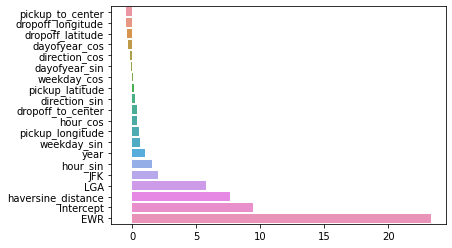

In [12]:
sns.barplot(x=ols.params.sort_values(), y=ols.params.sort_values().index)

## Basic Model

Here, I will use cross validation score (RMSE) to select a model for further training in large scale

### Linear regression

**LinearRegression**

In [16]:
%%time
# LinearRegression
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()

# cross validation 
from sklearn.model_selection import cross_validate
results = cross_validate(linear_reg, 
                         train[X], 
                         train[y], 
                         cv=10, 
                         scoring=['r2', 'neg_root_mean_squared_error'],
                         return_train_score=True)
print('        r2   rmse          ')
print('test:', 
      np.round(results['test_r2'].mean(), 3), 
      -np.round(results['test_neg_root_mean_squared_error'].mean(), 3))
print('train:', 
      np.round(results['train_r2'].mean(), 3), 
      -np.round(results['train_neg_root_mean_squared_error'].mean(), 3))

        r2   rmse          
test: 0.849 3.609
train: 0.849 3.609
Wall time: 29.3 s


### XGBoost
[scikit learn API for xgboost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [22]:
%%time
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_validate
xgb_reg = XGBRegressor(learning_rate=0.1, 
                   n_estimators=100, 
                   max_depth=5, 
                   min_child_weight=2)

results = cross_validate(xgb_reg, 
                            train[X],
                            train[y], 
                            cv=10, 
                            scoring=['r2', 'neg_root_mean_squared_error'],
                            return_train_score=True)
print('        r2   rmse          ')
print('test:', 
      np.round(results['test_r2'].mean(), 3), 
      -np.round(results['test_neg_root_mean_squared_error'].mean(), 3))
print('train:', 
      np.round(results['train_r2'].mean(), 3), 
      -np.round(results['train_neg_root_mean_squared_error'].mean(), 3))

        r2   rmse          
test: 0.894 3.03
train: 0.897 2.985
Wall time: 39min 33s


Compare to the model baseline RMSE = 9.76, this model performance (RMSE=3.03) is not bad!

## Model evaluation on the validation set
Here, I will train the model with train set and evaluate on val set and compare to the model baseline.

### preprocessing train set

In [52]:
%%time
# clean train set
train = feature_engineer(train)
train = clean_train(train)
# scaling
from sklearn.preprocessing import StandardScaler
scaling_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                   'year', 'haversine_distance',  'pickup_to_center', 'dropoff_to_center']
scaler = StandardScaler().fit(train[scaling_columns])
train[scaling_columns] = scaler.transform(train[scaling_columns])

Wall time: 4.01 s


### preprocessing validation set

In [53]:
%%time
# transforming
val = feature_engineer(val)
val.dropna(inplace=True)
# scaling
val[scaling_columns] = scaler.transform(val[scaling_columns])
val.describe()

Wall time: 2.35 s


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,dayofyear_cos,dayofyear_sin,weekday_cos,weekday_sin,...,haversine_distance,direction_sin,direction_cos,pickup_to_center,dropoff_to_center,JFK,LGA,EWR,east,west
count,200000.000000,200000.000000,200000.000000,199998.000000,199998.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,200000.000000,...,199998.000000,199998.000000,199998.000000,200000.000000,199998.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,11.338854,0.410285,-0.283123,0.422950,-0.158813,-0.001230,0.056617,6.373084e-01,-1.454327e-03,0.573339,...,-0.000513,0.025831,0.036549,0.637966,0.649311,0.022160,0.032335,0.001355,0.067125,0.001205
std,9.760548,3.106732,2.556254,3.400430,1.497014,0.998938,0.706038,3.035547e-01,7.328663e-01,0.366321,...,0.991888,0.618237,0.784720,4.727049,4.800676,0.147204,0.176889,0.036785,0.250239,0.034692
min,-20.900000,-191.716692,-40.931437,-328.078619,-22.845552,-2.006544,-1.000000,-3.216245e-16,-1.000000e+00,0.000000,...,-0.053112,-1.000000,-1.000000,-0.052610,-0.053262,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-0.023570,0.006877,-0.023260,0.003501,-0.933095,-0.664855,3.856634e-01,-8.660254e-01,0.500000,...,-0.049808,-0.503030,-0.828601,-0.040208,-0.039923,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.500000,-0.020578,0.013219,-0.019943,0.007309,0.140355,0.141540,7.055836e-01,6.123234e-17,0.500000,...,-0.047343,0.022709,0.104980,-0.032585,-0.032364,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.500000,-0.016332,0.018356,-0.015053,0.010295,0.677080,0.749826,9.209713e-01,8.660254e-01,0.866025,...,-0.042517,0.543773,0.870644,-0.024560,-0.023650,0.000000,0.000000,0.000000,0.000000,0.000000
max,450.000000,122.976251,581.110060,529.638462,388.086051,1.750529,1.000000,9.999907e-01,1.000000e+00,1.000000,...,23.624559,1.000000,1.000000,57.667884,63.848750,1.000000,1.000000,1.000000,1.000000,1.000000


### XGBRegressor

In [54]:
from xgboost.sklearn import XGBRegressor
xgb_reg = XGBRegressor(learning_rate=0.1, 
                   n_estimators=100, 
                   max_depth=5, 
                   min_child_weight=2)
# fit the model with 2 million data points
xgb_reg.fit(train[X], train[y])
# predict for validation set
y_pred = xgb_reg.predict(val[X])
# rmse
rmse = get_rmse(val[y], y_pred)
rmse

4.63438511340944

## Model evaluation on the test set
Here, I will train the model with 2 million entries and have a look at its performance on kaggle's test set.

### preprocessing train set

In [55]:
%%time
# read the train.csv directly from GCP cloud storage
url = 'gs://nyc_taxifare_predictor/data/train.csv'
df = pd.read_csv(url, nrows=2000000, encoding='utf-8')

Wall time: 25 s


In [56]:
%%time
# clean train set
df = feature_engineer(df)
df = clean_train(df)
# scaling
from sklearn.preprocessing import StandardScaler
scaling_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                   'year', 'haversine_distance',  'pickup_to_center', 'dropoff_to_center']
scaler = StandardScaler().fit(df[scaling_columns])
df[scaling_columns] = scaler.transform(df[scaling_columns])

Wall time: 17.4 s


### preprocessing test set

In [57]:
%%time
# read the test.csv directly from GCP cloud storage
url = 'gs://nyc_taxifare_predictor/data/test.csv'
test = pd.read_csv(url, encoding='utf-8')
test.shape

Wall time: 877 ms


(9914, 7)

In [58]:
%%time
# transforming
test = feature_engineer(test)
# scaling
test[scaling_columns] = scaler.transform(test[scaling_columns])
test.describe()

Wall time: 288 ms


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,dayofyear_cos,dayofyear_sin,weekday_cos,weekday_sin,hour_cos,...,haversine_distance,direction_sin,direction_cos,pickup_to_center,dropoff_to_center,JFK,LGA,EWR,east,west
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9.914000e+03,9914.000000,9914.000000,...,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-0.018645,0.012995,-0.018095,0.007424,0.041364,-0.071042,0.655515,5.955492e-02,0.555424,-0.099541,...,-0.043746,0.040523,0.022812,-0.031232,-0.030627,0.022493,0.031269,0.001210,0.048316,0.001110
std,0.012508,0.012432,0.011557,0.007413,0.967921,0.689522,0.299784,7.461754e-01,0.362283,0.640833,...,0.010839,0.620869,0.782598,0.017337,0.016410,0.148289,0.174052,0.034772,0.214443,0.033293
min,-0.099786,-0.052943,-0.103749,-0.030811,-1.469640,-0.999963,0.000000,-1.000000e+00,0.000000,-0.999998,...,-0.053119,-1.000000,-1.000000,-0.052349,-0.053126,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.023844,0.007466,-0.023298,0.003975,-0.932931,-0.720667,0.425000,-8.660254e-01,0.500000,-0.644457,...,-0.049577,-0.493944,-0.838912,-0.040549,-0.039839,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.020868,0.013740,-0.019976,0.007910,0.140488,-0.098820,0.723644,6.123234e-17,0.500000,-0.165048,...,-0.047069,0.087714,0.077178,-0.032990,-0.032526,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-0.016683,0.018952,-0.015256,0.010983,1.213907,0.556017,0.936881,8.660254e-01,0.866025,0.494321,...,-0.042082,0.559623,0.857969,-0.025292,-0.024047,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.270332,0.368271,0.272566,0.205103,1.750616,1.000000,0.999991,1.000000e+00,1.000000,0.999979,...,0.219725,1.000000,1.000000,0.483621,0.483604,1.000000,1.000000,1.000000,1.000000,1.000000


### XGBRegressor

In [59]:
from xgboost.sklearn import XGBRegressor
xgb_reg = XGBRegressor(learning_rate=0.1, 
                   n_estimators=200, 
                   max_depth=5, 
                   min_child_weight=2)
# fit the model with 2 million data points
xgb_reg.fit(df[X], df[y])
# predict for test
test['fare_amount'] = xgb_reg.predict(test[X])
# save the output as csv
test[['fare_amount']].to_csv('nyc_taxifare_xgboost_prediction.csv')

Submitted the result on kaggle, the score is **3.28**

## Model Tuning

For model tuning, I will use MLflow. For that, I will refactor my data cleaning, processing, feature engineering codes and setup a training pipeline. 

----------- check out refactoring notebook --------------------